<font size="5"><b><center>SJG017 - DK118: RNA velocity</center></b></font>

Load the required libraries

In [1]:
import anndata
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy 
import scipy as scp

%matplotlib inline

Convert in R the Seurat object we want to import with: 

Load the h5ad Seurat object 

In [2]:
DK118 = scanpy.read_h5ad("DK118.h5ad")

Let's analyse its content:

In [3]:
DK118

AnnData object with n_obs × n_vars = 2067 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'plate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.1', 'seurat_clusters', 'integrated_snn_res.0.2', 'integrated_snn_res.0.3', 'integrated_snn_res.0.4', 'integrated_snn_res.0.5', 'integrated_snn_res.0.6', 'integrated_snn_res.0.7', 'integrated_snn_res.0.8', 'integrated_snn_res.0.9', 'integrated_snn_res.1', 'replicate', 'rnaClusterID', 'nCount_TMM', 'nFeature_TMM', 'tmm_snn_res.0.1', 'tmm_snn_res.0.2', 'tmm_snn_res.0.3', 'tmm_snn_res.0.4', 'tmm_snn_res.0.5', 'tmm_snn_res.0.6', 'tmm_snn_res.0.7', 'tmm_snn_res.0.8', 'tmm_snn_res.0.9', 'tmm_snn_res.1', 'adtClusterID'
    var: 'features', 'SCT_features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap', 'X_umap_tmm'
    varm: 'PCs'
    layers: 'SCT'
    obsp: 'distances'

This is an AnnData object: AnnData stores a data matrix X (which in our case corresponds to the SCT normalized assay from Seurat) together with annotations of observations obs (obsm, obsp), variables var (varm, varp), and unstructured annotations uns. Here, we can see that among the observations we find all the data and metadata that we have produced in the previous analysis with Seurat in R. For example, the variables contain the annotated genes, however, two types of gene columns are reported. For convenience, it would better to maintain just one column, and/or to have a "Gene" column only on which the next analysis will rely. Hence, the first thing that we do is checking if the two columns are the same.

In [4]:
set(DK118.var.features) == set(DK118.var.SCT_features)

True

The columns "feature" and "SCT_features" contain the same values. We can drop one of the two, and rename the remaining one to "Gene".

In [5]:
DK118.var.drop("SCT_features", axis = 1, inplace = True)
DK118.var.columns = ["Gene"]

Next, we need to include the spliced and the unspliced counts. They are included in Loom files that we have produced using the original sample-specific FASTQ files using the following bash script

At this point, the script can be called via the command line using a for loop iterating on all the FASTQs

The Loom file format is designed to efficiently hold large omics datasets: typically, such data takes the form of a large matrix of numbers, along with metadata for the rows and columns. Therefore, they are very similar to h5ad file format and they can be easily converted one to the other. Indeed, both of the formats can be read as AnnData objects.

We have triplicates for each of the four condition samples (NT, AG, R, RAG), therefore, 12 Loom files in total. All the files can be concatenated in a single one, obtaining a final AnnData object with the spliced and unspliced counts of all the cells. This information has to be merged with our Seurat-based data, that contains the pre-processed and batch corrected expression data.

Nevertheless, in the single Loom files the cells are indexed with their UMIs, whereas in the Seurat object we have their project cell IDs: to merge the spliced/unspliced counts with our Seurat object, we need to convert the UMIs to cell IDs.

In [6]:
#Conversion table for 1-384 UMIs
conversion_table = pd.read_table("/scratch/karjosukarso/DK-118/CONFIG_FILES/barcodes_umis_1-384.tab", dtype = "str")
conversion_table.columns = ["barcode", "UMI"]
conversion_table = pd.Series(conversion_table.barcode.values,index=conversion_table.UMI).to_dict()

In [7]:
'''This function converts UMIs into CellIDs for specific loom files'''
def barcode2cellID(loom_file_path, sample_sheet_path):
    anndata_file = anndata.read_loom(loom_file_path)
    sample_sheet = pd.read_table(sample_sheet_path)
    bc2cellID_conversion = pd.Series(sample_sheet.project.values,index=sample_sheet.cel_barcode).to_dict()
    barcodes = [conversion_table.get(bc) for bc in anndata_file.obs.barcode]
    cellIDs = [bc2cellID_conversion.get(bc) for bc in barcodes]
    cellIDs = pd.DataFrame({"CellID" : cellIDs})
    cellIDs = cellIDs.set_index("CellID")
    anndata_file.obs = cellIDs
    
    #In the annotations there are two columns that are identical: gene_id and gene_name. One can be dropped
    anndata_file.var.drop("gene_id", axis = 1, inplace = True)
    anndata_file.var.columns = ["Gene"]
    anndata_file.var.index = anndata_file.var["Gene"]
    
    #We filter the cells and the genes present in this object according to the Seurat object
    anndata_file = anndata_file[np.isin(anndata_file.obs.index, DK118.obs.index)]
    
    return anndata_file

In [8]:
NT_1 = barcode2cellID("/scratch/adini/RNA_protein_velocity/DK-118/RNA/INVDK118-RNA_1465_lane1_25/counts_unfiltered/adata.loom",
                     "/scratch/karjosukarso/DK-118/CONFIG_FILES/sample_sheet_1465.txt")
NT_2 = barcode2cellID("/scratch/adini/RNA_protein_velocity/DK-118/RNA/INVDK118-RNA_1466_lane1_26/counts_unfiltered/adata.loom",
                     "/scratch/karjosukarso/DK-118/CONFIG_FILES/sample_sheet_1466.txt")
NT_3 = barcode2cellID("/scratch/adini/RNA_protein_velocity/DK-118/RNA/INVDK118-RNA_1467_lane1_27/counts_unfiltered/adata.loom",
                     "/scratch/karjosukarso/DK-118/CONFIG_FILES/sample_sheet_1467.txt")

AG_1 = barcode2cellID("/scratch/adini/RNA_protein_velocity/DK-118/RNA/INVDK118-RNA_1469_lane1_29/counts_unfiltered/adata.loom",
                     "/scratch/karjosukarso/DK-118/CONFIG_FILES/sample_sheet_1469.txt")
AG_2 = barcode2cellID("/scratch/adini/RNA_protein_velocity/DK-118/RNA/INVDK118-RNA_1470_lane1_30/counts_unfiltered/adata.loom",
                     "/scratch/karjosukarso/DK-118/CONFIG_FILES/sample_sheet_1470.txt")

R_1 = barcode2cellID("/scratch/adini/RNA_protein_velocity/DK-118/RNA/INVDK118-RNA_1471_lane1_31/counts_unfiltered/adata.loom",
                    "/scratch/karjosukarso/DK-118/CONFIG_FILES/sample_sheet_1471.txt")
R_2 = barcode2cellID("/scratch/adini/RNA_protein_velocity/DK-118/RNA/INVDK118-RNA_1472_lane1_32/counts_unfiltered/adata.loom",
                    "/scratch/karjosukarso/DK-118/CONFIG_FILES/sample_sheet_1472.txt")
R_3 = barcode2cellID("/scratch/adini/RNA_protein_velocity/DK-118/RNA/INVDK118-RNA_1473_lane1_33/counts_unfiltered/adata.loom",
                    "/scratch/karjosukarso/DK-118/CONFIG_FILES/sample_sheet_1473.txt")

RAG_1 = barcode2cellID("/scratch/adini/RNA_protein_velocity/DK-118/RNA/INVDK118-RNA_1474_lane1_34/counts_unfiltered/adata.loom",
                      "/scratch/karjosukarso/DK-118/CONFIG_FILES/sample_sheet_1474.txt")
RAG_2 = barcode2cellID("/scratch/adini/RNA_protein_velocity/DK-118/RNA/INVDK118-RNA_1476_lane1_35/counts_unfiltered/adata.loom",
                      "/scratch/karjosukarso/DK-118/CONFIG_FILES/sample_sheet_1476.txt")
RAG_3 = barcode2cellID("/scratch/adini/RNA_protein_velocity/DK-118/RNA/INVDK118-RNA_1477_lane1_36/counts_unfiltered/adata.loom",
                      "/scratch/karjosukarso/DK-118/CONFIG_FILES/sample_sheet_1477.txt")

Every sample contains an AnnData object with the spliced and unspliced counts, which are stored in the slot "layers". We can concatenate all the objects to obtain a unique one for the entire dataset before merging it with the Seurat object, to ultimately integrate the pre-processed and SCT normalized expression data with the spliced and unspliced counts.

In [9]:
DK118_concat = NT_1.concatenate(NT_2, NT_3, AG_1, AG_2, R_1, R_2, R_3, RAG_1, RAG_2, RAG_3)

In the cell ID index of the 12 samples the batch number is included, separated by a dash (-) from the actual cell ID, whereas it is absent in the cell IDs stored in the Seurat object. Therefore, we need to remove it.

In [10]:
DK118_concat.obs.index = DK118_concat.obs.index.str.split("-").str[0]

Now, we are ready to merge the Seurat object with the spliced and unspliced counts for each sample. In particular, since we want to use our pre-processed data, we assign to the main expression matrix X the SCT-normalized data, stored in the "SCT" layer.

In [11]:
DK118_final = scv.utils.merge(DK118_concat, DK118)
del DK118_final.layers["matrix"]
DK118_final.X = DK118_final.layers["SCT"]

Since we aim at computing protein accelerations, we need to add a layer and save the object as Loom file.

In [12]:
DK118_final.layers["ambiguous"] = scp.sparse.csr_matrix(np.zeros(DK118_final.X.shape))
DK118_final.write_loom("DK118.loom", write_obsm_varm = True)

<font size="5">RNA velocity</font>

Velocities are vectors in gene expression space and represent the direction and speed of movement of the individual cells. The velocities are obtained by modeling transcriptional dynamics of splicing kinetics, either stochastically (default), deterministically (by setting mode='deterministic'), or dynamically (by setting mode='dynamical'). For each gene, a steady-state-ratio of pre-mature (unspliced) and mature (spliced) mRNA counts is fitted, which constitutes a constant transcriptional state. Velocities are then obtained as residuals from this ratio. Positive velocity indicates that a gene is up-regulated, which occurs for cells that show higher abundance of unspliced mRNA for that gene than expected in steady state. Conversely, negative velocity indicates that a gene is down-regulated.

Before computing the velocities, we need to compute the moments for the velocity estimation. More specifically, first order moments for the spliced and unspliced counts are computed.

In [13]:
scv.pp.moments(DK118_final)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:15) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


<font size="4">Stochastical mode</font>

In [14]:
scv.tl.velocity(DK118_final, mode = "stochastic")

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [15]:
pd.DataFrame(DK118_final.layers["velocity"])

,0,1,2,3,4,5,6,7,8,9,...,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075
0,0.006032,0.0,0.029193,0.000000,0.0,0.000000,0.100691,0.000000,-0.014353,0.073010,...,0.189827,-0.017098,0.0,0.000000,0.003254,0.013379,0.0,0.0,0.024232,-0.004818
1,0.016196,0.0,0.000000,0.017000,0.0,0.041611,0.101745,-0.002708,0.063183,0.000877,...,-0.024017,-0.013285,0.0,0.000000,0.000555,-0.001059,0.0,0.0,-0.004614,0.038917
2,0.009857,0.0,0.048541,0.018300,0.0,-0.008760,0.178129,0.027613,-0.048583,0.004856,...,-0.022497,-0.008538,0.0,0.014541,0.006360,-0.001410,0.0,0.0,0.034639,0.012533
3,0.005909,0.0,0.031472,0.000000,0.0,-0.005726,0.183533,0.019620,-0.139737,0.018354,...,-0.003953,-0.011351,0.0,-0.015550,-0.009040,-0.002522,0.0,0.0,0.025138,0.016387
4,0.021240,0.0,0.000000,0.021240,0.0,0.000000,0.001664,0.051029,0.061780,0.062028,...,-0.015858,-0.017012,0.0,0.000000,0.028258,-0.004330,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,0.007932,0.0,0.004947,0.002809,0.0,0.017482,0.172878,0.028306,0.012935,0.013812,...,-0.030756,-0.030402,0.0,0.000000,0.041587,0.005698,0.0,0.0,0.021558,0.008405
2060,-0.020207,0.0,0.029304,0.037882,0.0,0.068873,-0.057697,0.000000,-0.005962,-0.007876,...,-0.039185,-0.015794,0.0,-0.004692,-0.001386,-0.004679,0.0,0.0,-0.033691,0.007889
2061,0.000000,0.0,0.000000,0.038148,0.0,0.038223,0.034695,0.000000,0.201636,0.153625,...,0.000000,-0.010661,0.0,0.000000,0.051917,0.000000,0.0,0.0,0.108078,0.000000
2062,0.000000,0.0,0.041026,0.018616,0.0,0.000000,-0.145862,0.000000,0.157437,-0.013772,...,-0.011046,-0.016219,0.0,0.028061,-0.005992,0.018688,0.0,0.0,0.020938,0.003520


The velocities are stored in DK118_final.layers as the count matrixes. The combination of velocities across genes can then be used to estimate the future state of an individual cell. In order to project the velocities into a lower-dimensional embedding, transition probabilities of cell-to-cell transitions are estimated. That is, for each velocity vector we find the likely cell transitions that are accordance with that direction. The transition probabilities are computed using cosine correlation between the potential cell-to-cell transitions and the velocity vector, and are stored in a matrix denoted as velocity graph. The resulting velocity graph has dimension nobs×nobs and summarizes the possible cell state changes that are well explained through the velocity vectors.

In [16]:
scv.tl.velocity_graph(DK118_final)

computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


The velocities can now be projectes onto any embedding, specified by the basis, and visualized in one of these ways: 
- as streamlines with scv.pl.velocity_embedding_stream,
- on cellular level with scv.pl.velocity_embedding, 
- as gridlines with scv.pl.velocity_embedding_grid. 

At our disposal, we will have two main embeddings: umap and umap_tmm.

<font size="4">Streamlines visualization</font>

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_streamlines_UMAP_SCT_RNAclusters.svg


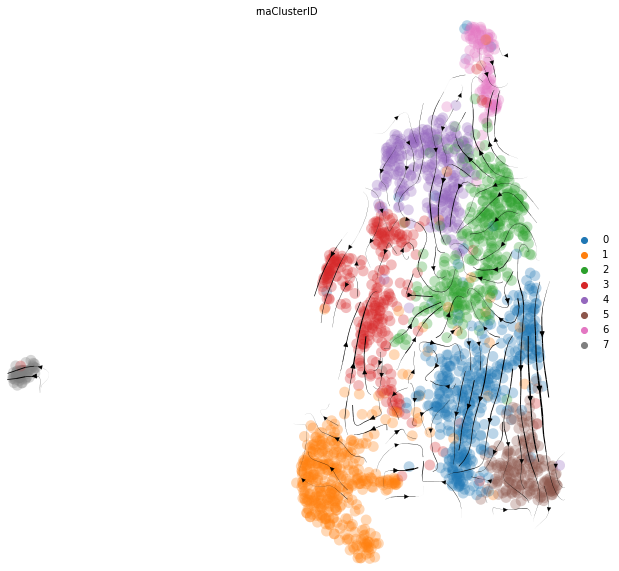

In [17]:
scv.pl.velocity_embedding_stream(DK118_final, 
                                 basis = "X_umap", 
                                 legend_loc = "right margin", 
                                 color = "rnaClusterID", figsize=(10,10), save = "streamlines_UMAP_SCT_RNAclusters.svg")

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap_tmm', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_streamlines_UMAP_TMM_ADTclusters.svg


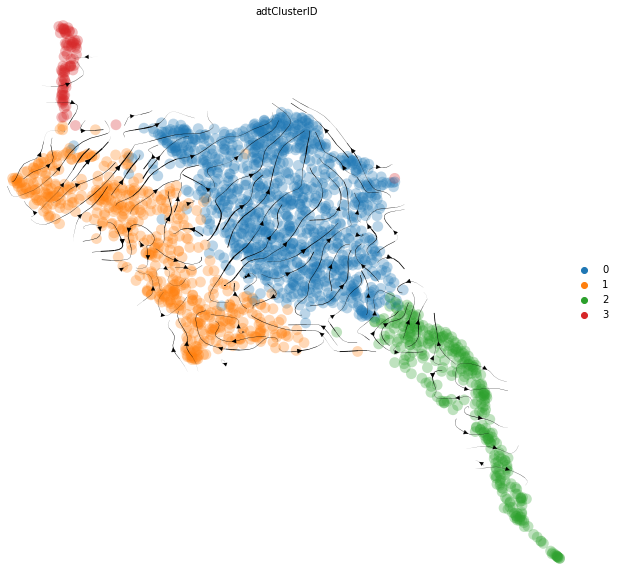

In [18]:
scv.pl.velocity_embedding_stream(DK118_final, 
                                 basis = "X_umap_tmm", 
                                 legend_loc = "right margin", 
                                 color = "adtClusterID", figsize=(10,10), save = "streamlines_UMAP_TMM_ADTclusters.svg")

saving figure to file ./figures/scvelo_streamlines_UMAP_SCT_conditions.svg


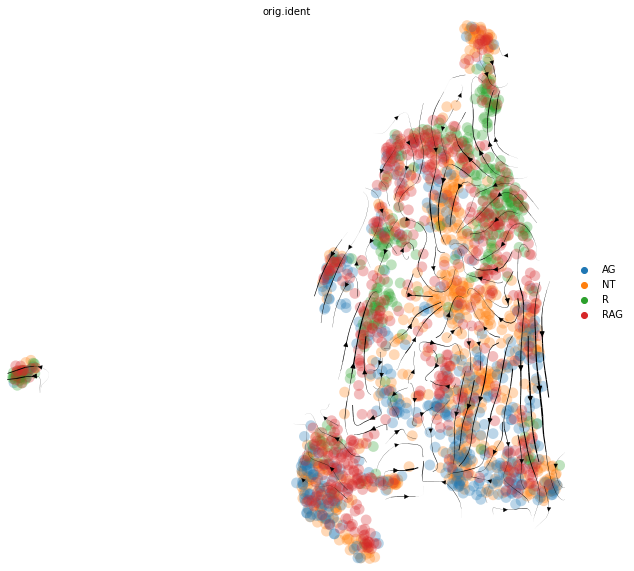

In [19]:
scv.pl.velocity_embedding_stream(DK118_final, 
                                 basis = "X_umap", 
                                 legend_loc = "right margin", 
                                 color = "orig.ident", figsize=(10,10), save = "streamlines_UMAP_SCT_conditions.svg")

saving figure to file ./figures/scvelo_streamlines_UMAP_TMM_conditions.svg


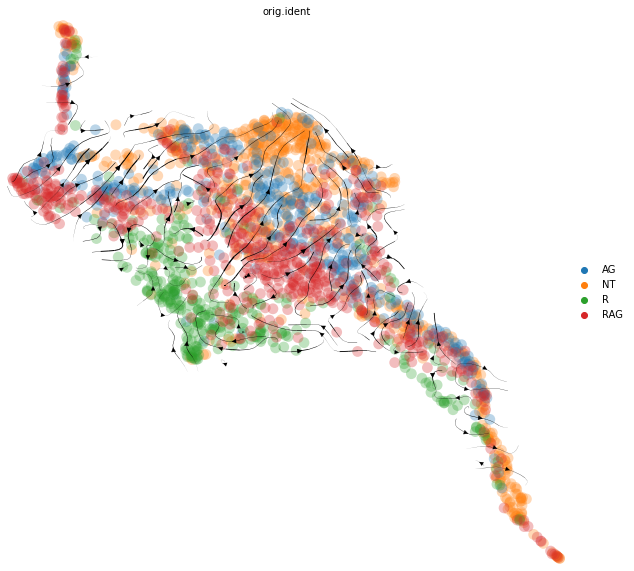

In [20]:
scv.pl.velocity_embedding_stream(DK118_final, 
                                 basis = "X_umap_tmm", 
                                 legend_loc = "right margin", 
                                 color = "orig.ident", figsize=(10,10), save = "streamlines_UMAP_TMM_conditions.svg")

<font size="4">Cellular-level visualization</font>

saving figure to file ./figures/scvelo_celllines_UMAP_SCT_RNAclusters.svg


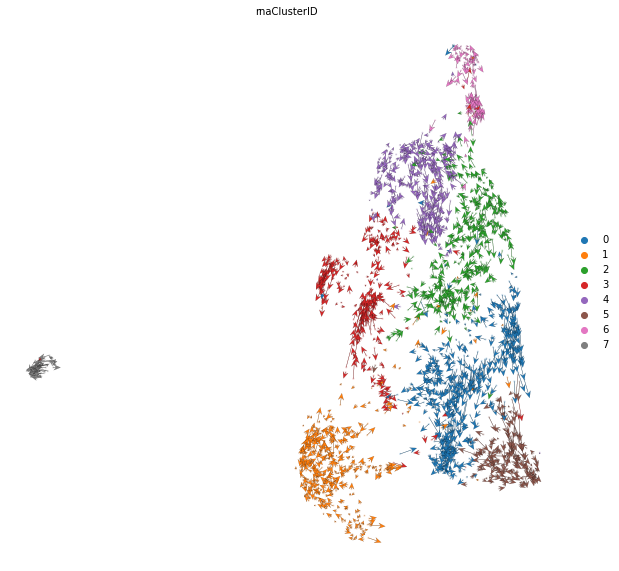

In [21]:
scv.pl.velocity_embedding(DK118_final,
                          basis = "X_umap",
                          color = "rnaClusterID",
                          figsize = (10,10),
                          scale = 0.5,
                          legend_loc = "right_margin", 
                          arrow_length = 3, arrow_size = 2, size = 20, save = "celllines_UMAP_SCT_RNAclusters.svg")

saving figure to file ./figures/scvelo_celllines_UMAP_TMM_ADTclusters.svg


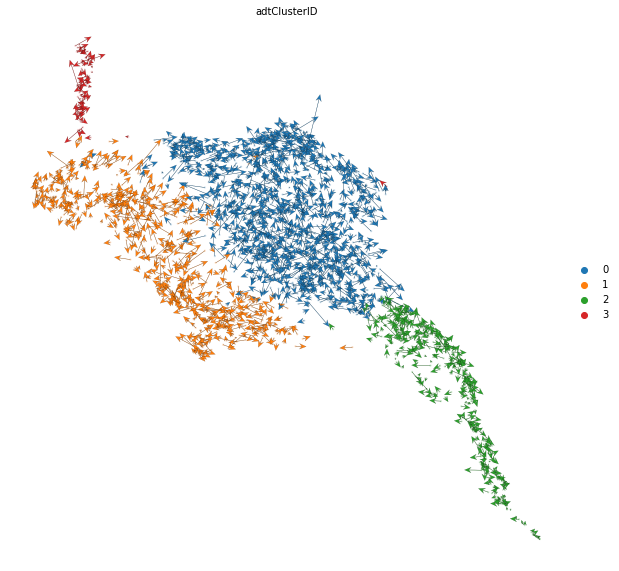

In [22]:
scv.pl.velocity_embedding(DK118_final,
                          basis = "X_umap_tmm",
                          color = "adtClusterID",
                          figsize = (10,10),
                          scale = 0.5,
                          legend_loc = "right_margin", 
                          arrow_length = 6, arrow_size = 2, size = 20, save = "celllines_UMAP_TMM_ADTclusters.svg")

saving figure to file ./figures/scvelo_celllines_UMAP_SCT_conditions.svg


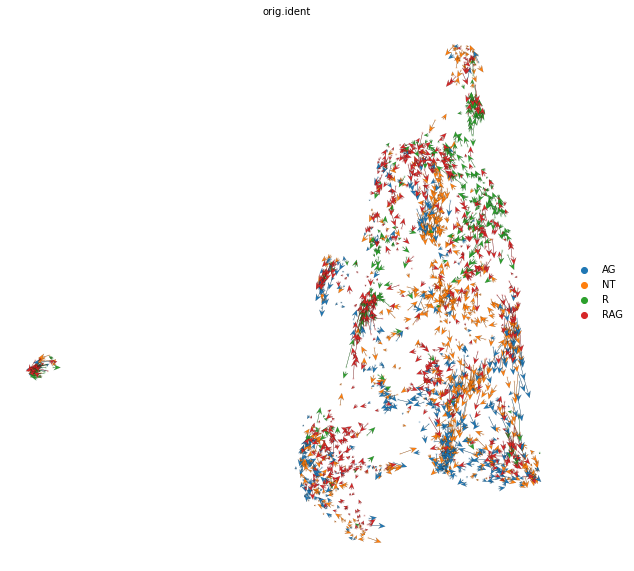

In [23]:
scv.pl.velocity_embedding(DK118_final,
                          basis = "X_umap",
                          color = "orig.ident",
                          figsize = (10,10),
                          scale = 0.5,
                          legend_loc = "right_margin", 
                          arrow_length = 3, arrow_size = 2, size = 20, save = "celllines_UMAP_SCT_conditions.svg")

saving figure to file ./figures/scvelo_celllines_UMAP_TMM_conditions.svg


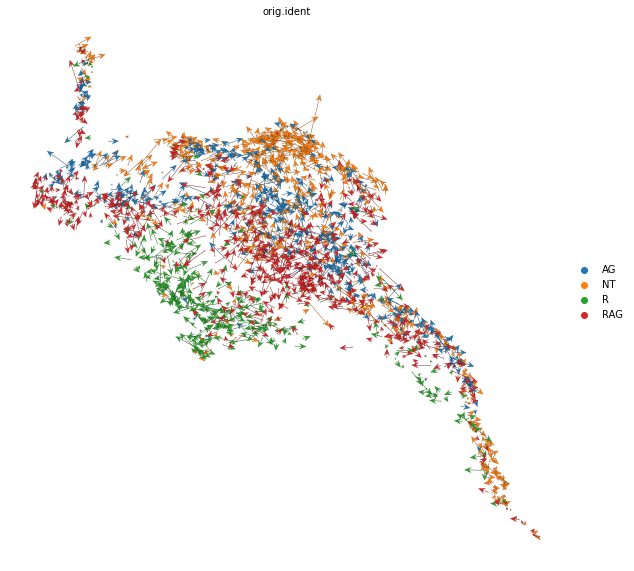

In [24]:
scv.pl.velocity_embedding(DK118_final,
                          basis = "X_umap_tmm",
                          color = "orig.ident",
                          figsize = (10,10),
                          scale = 0.5,
                          legend_loc = "right_margin", 
                          arrow_length = 6, arrow_size = 2, size = 20, save = "celllines_UMAP_TMM_conditions.svg")

<font size="4">Gridlines visualization</font>

saving figure to file ./figures/scvelo_gridlines_UMAP_SCT_RNAclusters.svg


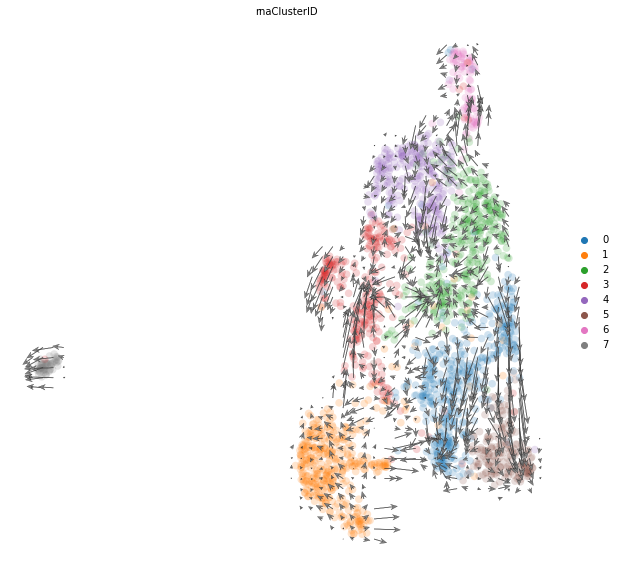

In [25]:
scv.pl.velocity_embedding_grid(DK118_final, 
                               basis = "X_umap", 
                               scale = 0.5, 
                               legend_loc = "right margin", 
                               color = "rnaClusterID", 
                               arrow_size = 2, arrow_length = 3, figsize = (10,10), save = "gridlines_UMAP_SCT_RNAclusters.svg")

saving figure to file ./figures/scvelo_gridlines_UMAP_TMM_ADTclusters.svg


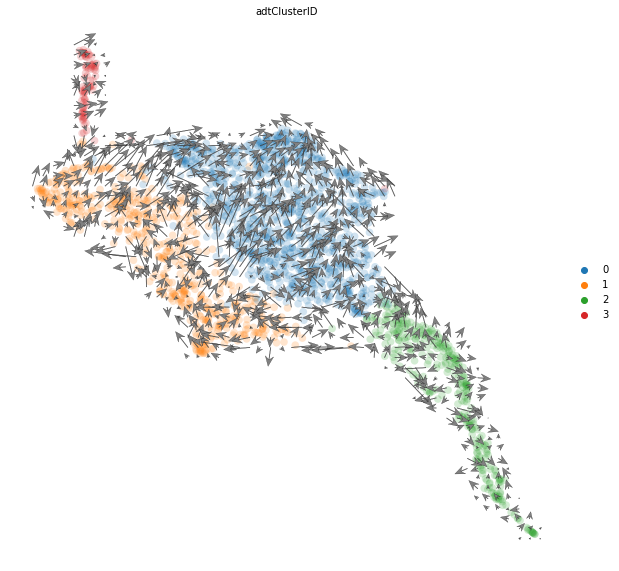

In [26]:
scv.pl.velocity_embedding_grid(DK118_final, 
                               basis = "X_umap_tmm", 
                               scale = 0.5, 
                               legend_loc = "right margin", 
                               color = "adtClusterID", 
                               arrow_size = 3, arrow_length = 5, figsize = (10,10), save = "gridlines_UMAP_TMM_ADTclusters.svg")

saving figure to file ./figures/scvelo_gridlines_UMAP_SCT_conditions.svg


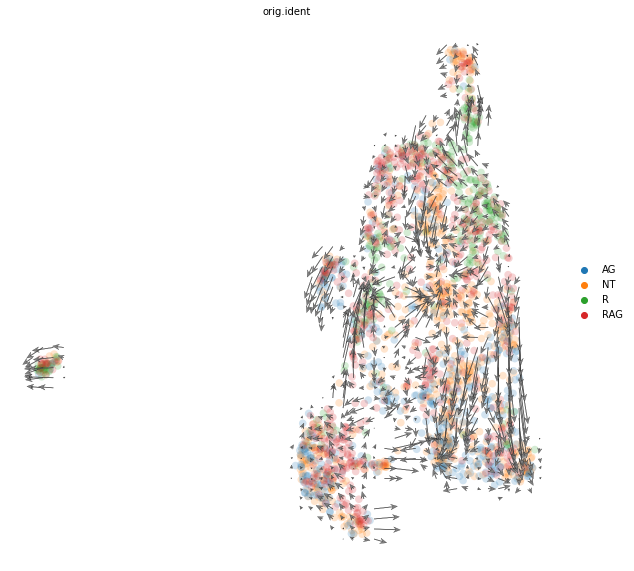

In [27]:
scv.pl.velocity_embedding_grid(DK118_final, 
                               basis = "X_umap", 
                               scale = 0.5, 
                               legend_loc = "right margin", 
                               color = "orig.ident", 
                               arrow_size = 2, arrow_length = 3, figsize = (10,10), save = "gridlines_UMAP_SCT_conditions.svg")

saving figure to file ./figures/scvelo_gridlines_UMAP_TMM_conditions.svg


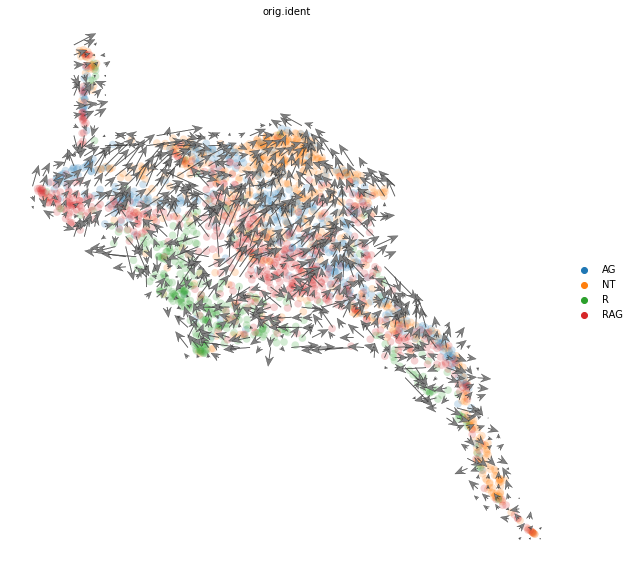

In [28]:
scv.pl.velocity_embedding_grid(DK118_final, 
                               basis = "X_umap_tmm", 
                               scale = 0.5, 
                               legend_loc = "right margin", 
                               color = "orig.ident", 
                               arrow_size = 3, arrow_length = 5, figsize = (10,10), save = "gridlines_UMAP_TMM_conditions.svg")

<font size="4">Speed and coherence</font>

Two more useful stats: 
- The speed or rate of differentiation is given by the length of the velocity vector. 
- The coherence of the vector field (i.e., how a velocity vector correlates with its neighboring velocities) provides a measure of confidence.

These provide insights where cells differentiate at a slower/faster pace, and where the direction is un-/determined.

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
saving figure to file ./figures/scvelo_speed_coherence_UMAP_SCT.svg


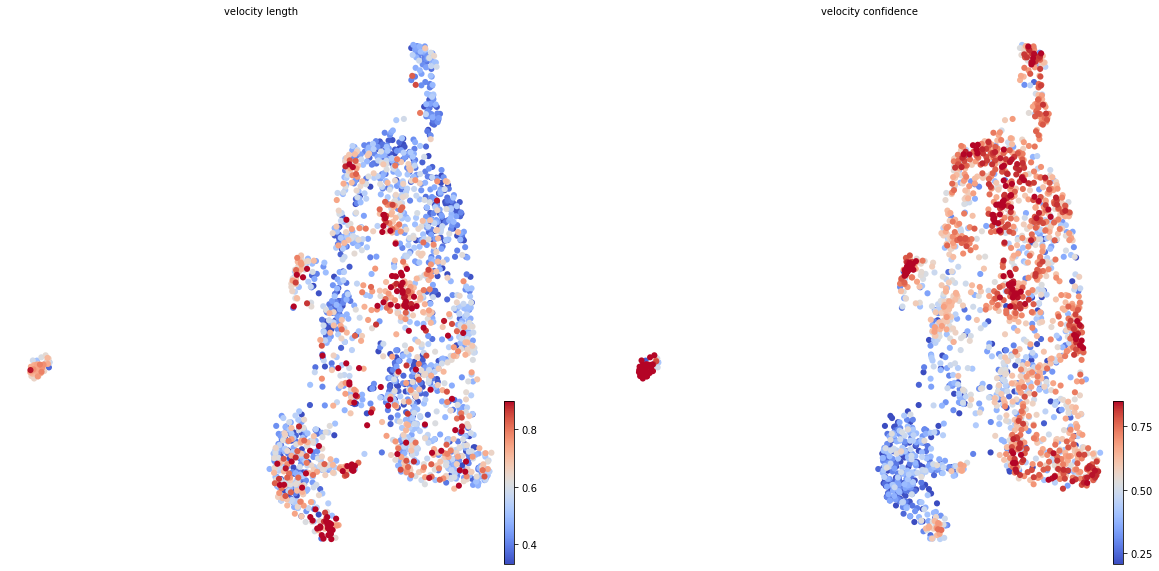

In [29]:
scv.tl.velocity_confidence(DK118_final)
keys = "velocity_length", "velocity_confidence"
scv.pl.scatter(DK118_final,
               basis = "X_umap",
               c = keys, 
               cmap = "coolwarm", 
               perc = [5, 95], 
               size = 150, 
               figsize = (10, 10), save = "speed_coherence_UMAP_SCT.svg")

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
saving figure to file ./figures/scvelo_speed_coherence_UMAP_TMM.svg


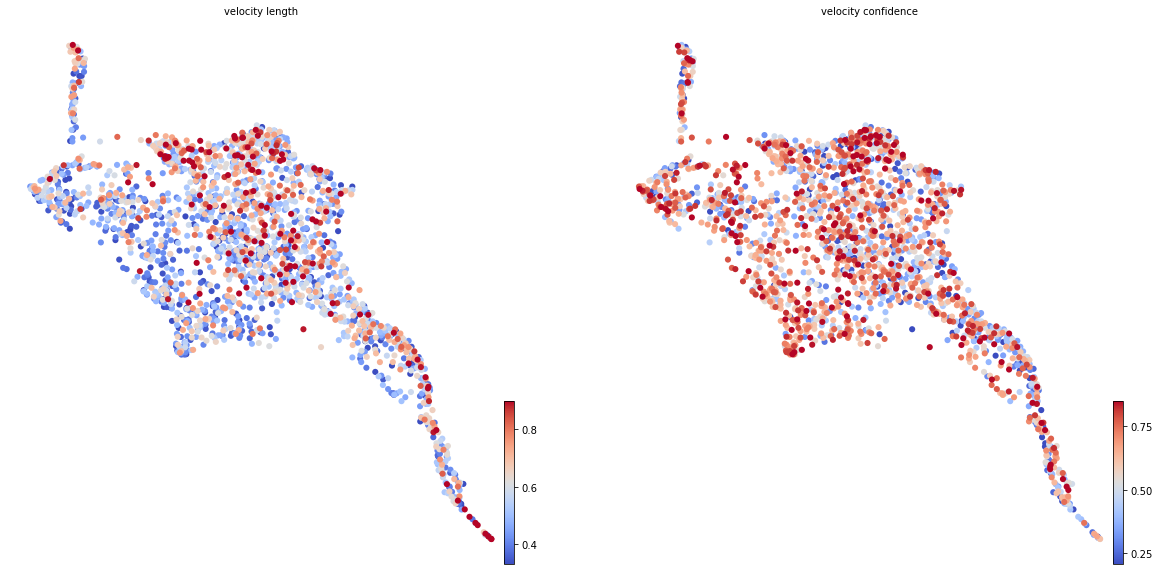

In [30]:
scv.tl.velocity_confidence(DK118_final)
keys = "velocity_length", "velocity_confidence"
scv.pl.scatter(DK118_final,
               basis = "X_umap_tmm",
               c = keys, 
               cmap = "coolwarm", 
               perc = [5, 95], 
               size = 150, 
               figsize = (10, 10), save = "speed_coherence_UMAP_TMM.svg")

In [31]:
speedcoherence_clusters = DK118_final.obs.groupby("rnaClusterID")[keys].mean().T
speedcoherence_clusters.style.background_gradient(cmap = "coolwarm", axis = 1)

rnaClusterID,0,1,2,3,4,5,6,7
velocity_length,0.546238,0.602482,0.563353,0.552305,0.555125,0.574535,0.441789,0.681818
velocity_confidence,0.562800,0.344621,0.636232,0.553728,0.688147,0.634023,0.696830,0.810629


In [32]:
speedcoherence_conditions = DK118_final.obs.groupby("orig.ident")[keys].mean().T
speedcoherence_conditions.style.background_gradient(cmap = "coolwarm", axis = 1)

orig.ident,AG,NT,R,RAG
velocity_length,0.607240,0.603642,0.487591,0.528042
velocity_confidence,0.517865,0.582110,0.642452,0.544503


In [33]:
speedcoherence_conditions = DK118_final.obs.groupby("adtClusterID")[keys].mean().T
speedcoherence_conditions.style.background_gradient(cmap = "coolwarm", axis = 1)

adtClusterID,0,1,2,3
velocity_length,0.599265,0.498569,0.566806,0.534938
velocity_confidence,0.562977,0.606765,0.517964,0.536088


<font size="4">Testing which genes have cluster-specific differential velocity expression</font>

The module scv.tl.rank_velocity_genes runs a differential velocity t-test and outpus a gene ranking for each cluster. Thresholds can be set (e.g. min_corr) to restrict the test on a selection of gene candidates.

In [34]:
scv.tl.rank_velocity_genes(DK118_final, groupby = "rnaClusterID", n_genes = 50)
ranked_velocities = scv.DataFrame(DK118_final.uns['rank_velocity_genes']['names'])
ranked_velocities

ranking velocity genes
    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


,0,1,2,3,4,5,6,7
0,FBXO32,STX2,LIMCH1,TPM2,CLTA,MIR205HG,CLTA,TPM2
1,MIR205HG,SERPINB13,SERPINB13,LIMCH1,LIMCH1,AURKA,TLN1,CLTA
2,CXCL14,HINT2,CXCL14,TLN1,TLN1,DSP,GBA2,LIMCH1
3,HINT2,DSP,TLN1,MIR205HG,CXCL14,RHCG,TPM2,TLN1
4,RHCG,AURKA,HINT2,FBXO32,RHCG,HINT2,STX2,GBA2
5,SERPINB13,GBA2,MIR205HG,GBA2,AURKA,FBXO32,MIR205HG,HINT2
6,DSP,TPM2,STX2,CLTA,STX2,TLN1,SERPINB13,STX2
7,GBA2,MIR205HG,DSP,HINT2,GBA2,GBA2,AURKA,FBXO32
8,CLTA,CXCL14,AURKA,AURKA,TPM2,STX2,LIMCH1,DSP
9,AURKA,RHCG,GBA2,RHCG,SERPINB13,CLTA,CXCL14,CXCL14


In [35]:
scv.tl.rank_velocity_genes(DK118_final, groupby = "orig.ident")
ranked_velocities = scv.DataFrame(DK118_final.uns['rank_velocity_genes']['names'])
ranked_velocities

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


,AG,NT,R,RAG
0,FBXO32,MIR205HG,TPM2,AURKA
1,HINT2,FBXO32,CLTA,DSP
2,RHCG,CXCL14,TLN1,SERPINB13
3,DSP,RHCG,LIMCH1,CLTA
4,MIR205HG,GBA2,STX2,LIMCH1
5,STX2,HINT2,SERPINB13,HINT2
6,GBA2,SERPINB13,CXCL14,STX2
7,AURKA,LIMCH1,GBA2,CXCL14
8,CXCL14,DSP,AURKA,GBA2
9,LIMCH1,TPM2,RHCG,TLN1


In [36]:
scv.tl.rank_velocity_genes(DK118_final, groupby = "adtClusterID")
ranked_velocities = scv.DataFrame(DK118_final.uns['rank_velocity_genes']['names'])
ranked_velocities

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


,0,1,2,3
0,FBXO32,TPM2,HINT2,MIR205HG
1,MIR205HG,TLN1,STX2,STX2
2,DSP,CLTA,SERPINB13,AURKA
3,RHCG,LIMCH1,AURKA,GBA2
4,HINT2,CXCL14,MIR205HG,FBXO32
5,CXCL14,SERPINB13,DSP,TPM2
6,GBA2,STX2,GBA2,CXCL14
7,AURKA,AURKA,RHCG,SERPINB13
8,LIMCH1,GBA2,FBXO32,HINT2
9,CLTA,RHCG,LIMCH1,RHCG


Here, the proportions of spliced/unspliced counts are displayed. 

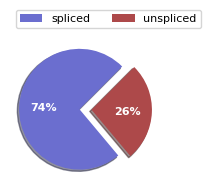

In [37]:
scv.pl.proportions(DK118_final)

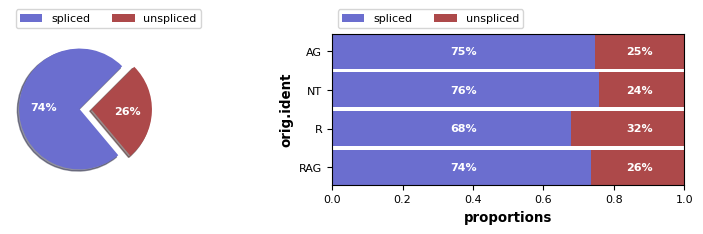

In [38]:
scv.pl.proportions(DK118_final, groupby="orig.ident")

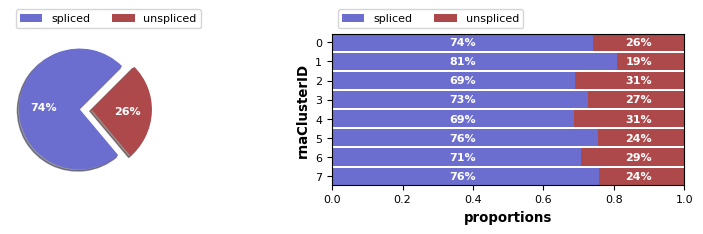

In [39]:
scv.pl.proportions(DK118_final, groupby="rnaClusterID")

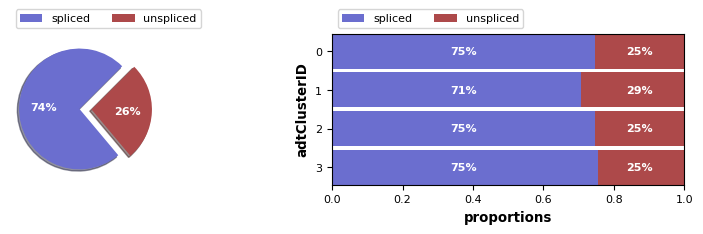

In [40]:
scv.pl.proportions(DK118_final, groupby="adtClusterID")